
# Project 1 - Finding the Lane Lines on the Road¶


### Import the Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

### Import the test images

In [2]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

In [3]:

# image = mpimg.imread('test_images/solidWhiteCurve.jpg')

# # #printing out some stats and plotting
# # print('This image is:', type(image), 'with dimensions:', image.shape)
# plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [4]:
import math

def grayscale(img):
#     """Applies the Grayscale transform
#     This will return an image with only one color channel
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#### Class for displaying images

In [5]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

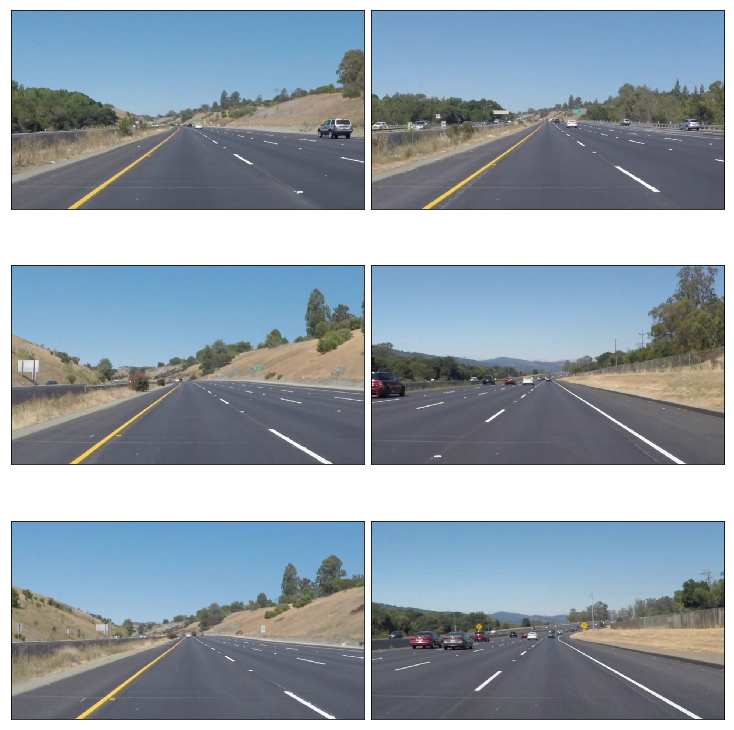

In [6]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

show_images(test_images)

### Grayscaling of images

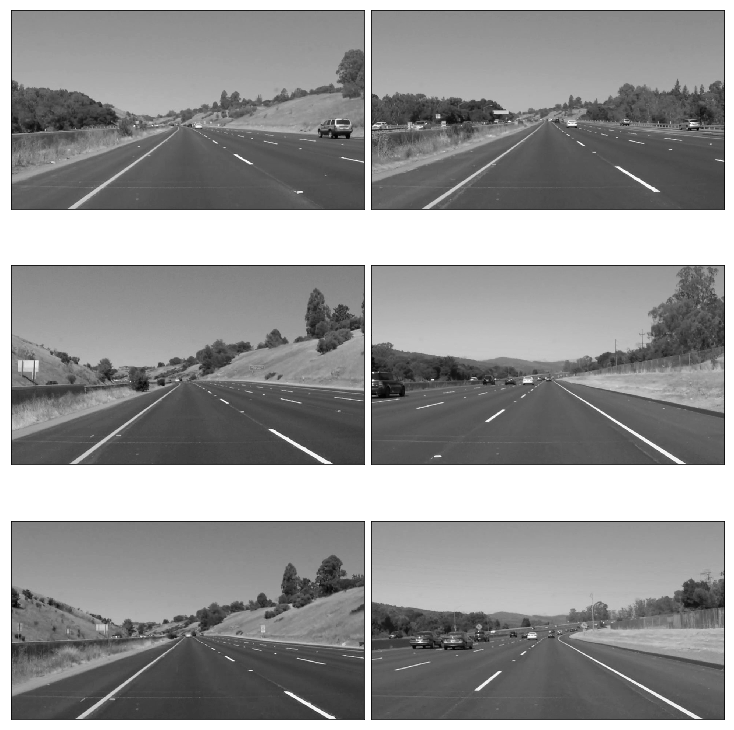

In [7]:
gray_images=list(map(grayscale, test_images))
show_images(gray_images)

### Gaussion Blurring

In [8]:
def gaussian_blur(img, kernel_size=3):
#     """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


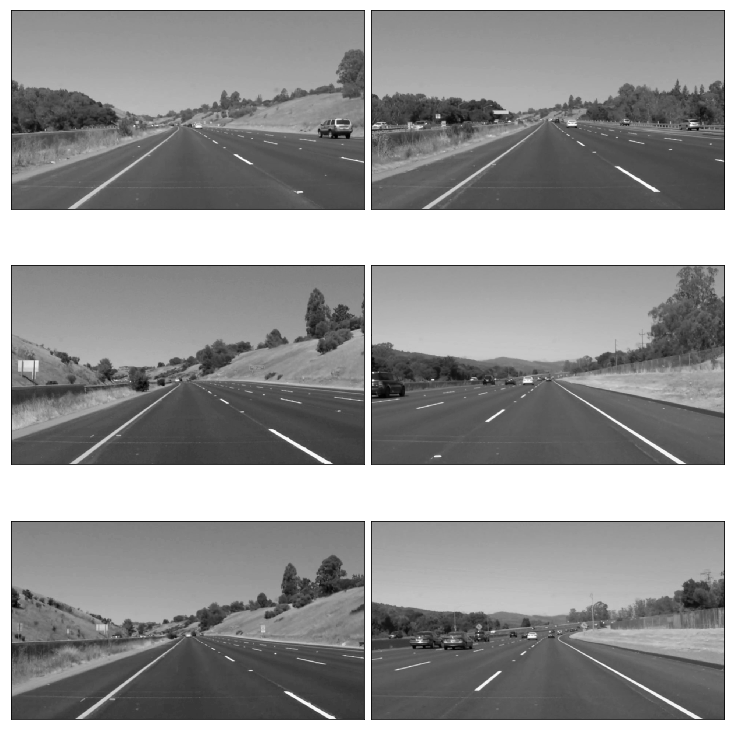

In [9]:

blur_gray= list(map(gaussian_blur, gray_images))
show_images(blur_gray)


### Canny Edge Detection

In [10]:
def canny(img, low_threshold=47, high_threshold=141):
#     """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


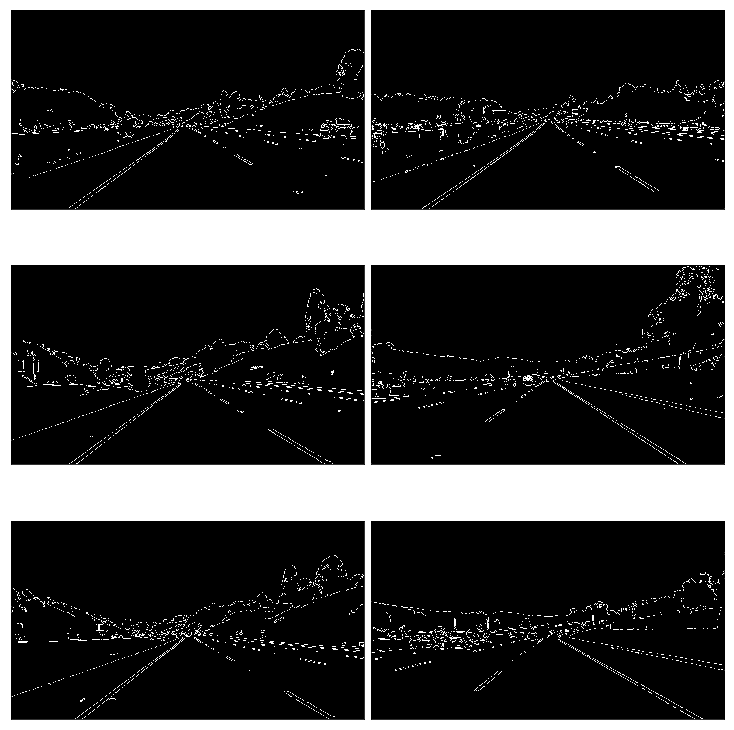

In [11]:
canny_image=list(map(canny, blur_gray))
show_images(canny_image)

### Region masking

In [12]:

def region_of_interest(img, vertices=np.array([[(100,550),(480, 310), (980,500)]], dtype=np.int32)):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

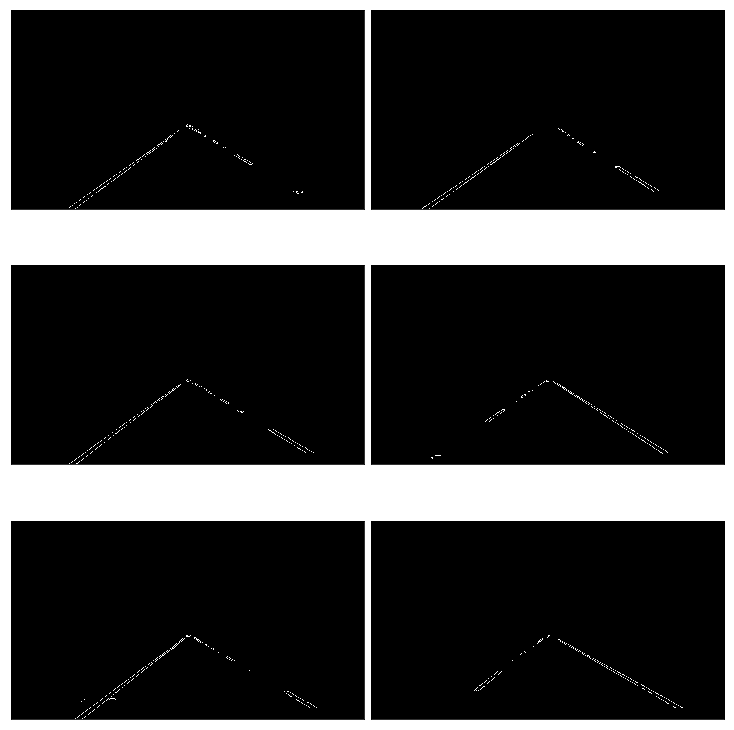

In [13]:
masked_image=list(map(region_of_interest, canny_image))
show_images(masked_image)

### Drawing-line and Extrapolation Function 

In [14]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    leftpoints_x1=[]
    leftpoints_y1=[]
    rightpoints_x1=[]
    rightpoints_y1=[]
    left_slopes=[]
    right_slopes=[]
    
    
    for line in lines:

        for x1,y1,x2,y2 in line:
            m=((y2-y1)/(x2-x1)) #calculating slope
 
            if m<0:             #segregating left and right slopes
                left_slopes.append(m)
                leftpoints_x1.extend((x1,x2))
                leftpoints_y1.extend((y1,y2))
            else:
                right_slopes.append(m)
                rightpoints_x1.extend((x1,x2))
                rightpoints_y1.extend((y1,y2))

    # taking mean of left slopes & right slopes
    Ls_mean, Rs_mean= np.nanmean(left_slopes) ,np.nanmean(right_slopes)

    #taking mean of left x pts, left y pts, right x pts, right y points
    Lx_mean,Ly_mean,Rx_mean,Ry_mean= np.nanmean(leftpoints_x1),np.nanmean(leftpoints_y1),np.nanmean(rightpoints_x1),np.nanmean(rightpoints_y1)

    # calculating intercepts for left and right, b=y-mx
    left_intercept= Ly_mean-(Ls_mean*Lx_mean)    
    right_intercept= Ry_mean-(Rs_mean*Rx_mean)

    #drawing new line on left with x=(y-b)/m, with Yu_1=upper & Yd_l=down
    Yu_l, Yd_l = 330, 550
    Lx_u= int((Yu_l-left_intercept)/Ls_mean)
    Lx_d= int((Yd_l-left_intercept)/Ls_mean)
    cv2.line(img, (Lx_d, Yd_l), (Lx_u, Yu_l), color, thickness)

    #drawing new line on right with x=(y-b)/m, with Yu_r=upper & Yd_r=down
    Yu_r,Yd_r= 330,550
    Rx_u= int((Yu_r-right_intercept)/Rs_mean)
    Rx_d= int((Yd_r-right_intercept)/Rs_mean)
    cv2.line(img, (Rx_d, Yd_r), (Rx_u, Yu_r), color, thickness)


### Hough Transform

In [15]:
def hough_lines(img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=500):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,color=[255, 0, 0], thickness=10)
    return line_img

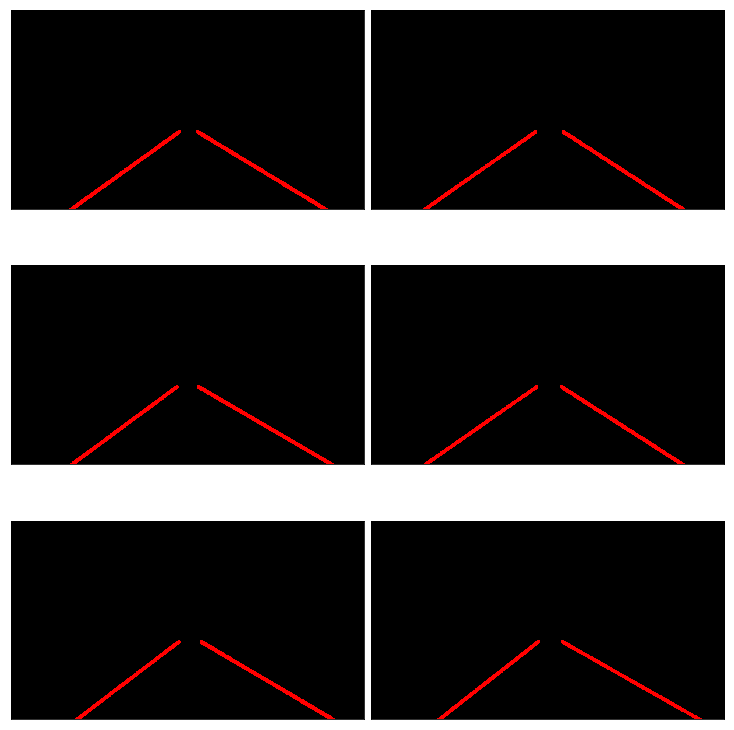

In [16]:
hough_image=list(map(hough_lines, masked_image))
show_images(hough_image)

### Combining the lanes with Original image

In [17]:
def weighted_img(img, initial_img, α=1.0, β=0.7, λ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, λ)

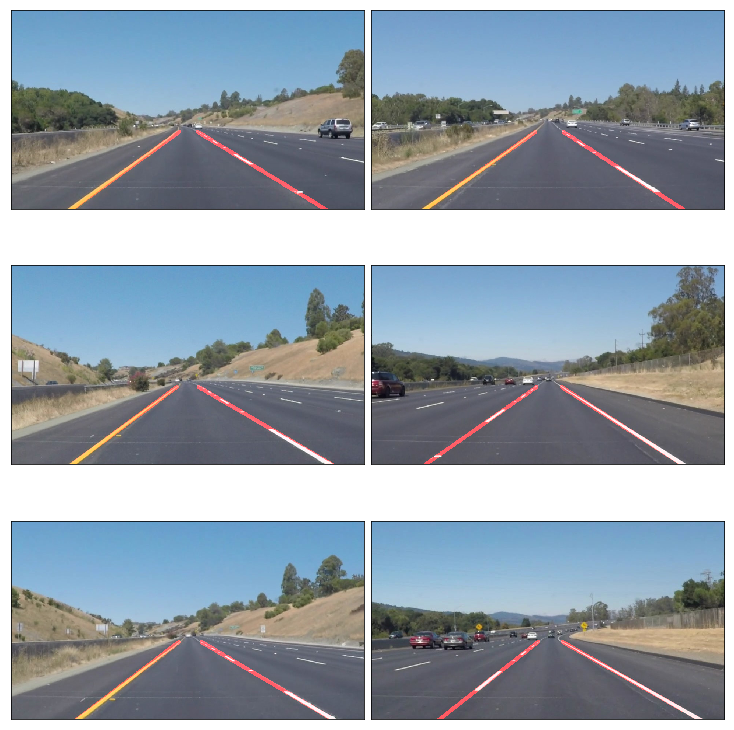

In [18]:

final_image=list(map(weighted_img, hough_image,test_images))
show_images(final_image)
save_images = [plt.savefig(final_image) for path in glob.glob('output_images/*.jpg')]

## Video Test - Lane detection

In [19]:
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):
    
    gray=grayscale(image)
    blur_gray= gaussian_blur(gray)
    canny_image= canny(blur_gray)
    masked_image= region_of_interest(canny_image)
    hough_image= hough_lines(masked_image)
    result= weighted_img(hough_image,image)
    return result

### White Lane on Right Video

#### Save in test_output ---> white

In [21]:
white_output = 'test_output/white.mp4'

# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_output/white.mp4
[MoviePy] Writing video test_output/white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/white.mp4 

CPU times: user 2.85 s, sys: 612 ms, total: 3.46 s
Wall time: 7.88 s


### HTML Display

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Yellow Lane on right Video

#### Save in test_output ---> yellow

In [23]:
yellow_output = 'test_output/yellow.mp4'

# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video test_output/yellow.mp4
[MoviePy] Writing video test_output/yellow.mp4


100%|█████████▉| 681/682 [00:22<00:00, 37.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/yellow.mp4 

CPU times: user 9.55 s, sys: 1.94 s, total: 11.5 s
Wall time: 23.3 s


### HTML Display

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))